<a href="https://colab.research.google.com/github/avikagupta03/Fraud_Detection_Comparison/blob/main/Fraud_Detection_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import random
from datetime import datetime, timedelta
from tabulate import tabulate

In [49]:
def generate_phone_number():
    country_code = random.choice(["+1", "+44", "+86"])
    area_code = f"{random.randint(100, 999)}"
    number = f"{random.randint(1000, 9999)}-{random.randint(1000, 9999)}"
    return country_code + area_code + "-" + number

In [50]:
def generate_call_time():
    start_date = datetime(2024, 6, 14)
    end_date = datetime(2024, 6, 15)
    random_time = start_date + (end_date - start_date) * random.random()
    return random_time

In [51]:
def generate_data_point():
    caller_number = generate_phone_number()
    call_time = generate_call_time()
    call_duration = random.randint(30, 600)
    caller_location = random.choice(["US", "UK", "China", "India"])
    silence_ratio = random.uniform(10, 80)
    speech_rate = random.randint(100, 250)
    background_noise = random.choice(["None", "Low traffic", "Call center chatter", "Music"])
    number_type = random.choice(["Mobile", "Landline", "Unknown"])
    previous_calls = random.randint(0, 10)
    typical_calling_hours = random.randint(0, 1)
    claimed_caller_id = random.choice(["Unknown", "Company X", "Delivery Service", "Your Bank"])
    fraud_label = random.randint(0, 1)

    return {
        "caller_number": caller_number,
        "call_time": call_time,
        "call_duration": call_duration,
        "caller_location": caller_location,
        "silence_ratio": silence_ratio,
        "speech_rate": speech_rate,
        "background_noise": background_noise,
        "number_type": number_type,
        "previous_calls": previous_calls,
        "typical_calling_hours": typical_calling_hours,
        "claimed_caller_id": claimed_caller_id,
        "fraud_label": fraud_label
    }

In [52]:
def generate_data(num_samples):
    data = [generate_data_point() for _ in range(num_samples)]
    return pd.DataFrame(data)

In [53]:
num_samples = 1000
data = generate_data(num_samples)
csv_filename = 'fraud-call.csv'
data.to_csv(csv_filename, index=False)
print(f"Synthetic data saved to {csv_filename}")
print(f"The shape of the DataFrame is: {data.shape}")

Synthetic data saved to fraud-call.csv
The shape of the DataFrame is: (1000, 12)


In [54]:
table_data = data[['caller_number', 'call_time', 'call_duration', 'caller_location',
                   'silence_ratio', 'speech_rate', 'background_noise', 'number_type',
                   'previous_calls', 'typical_calling_hours', 'claimed_caller_id']].values.tolist()

print(tabulate(table_data, headers=["Caller Number", "Call Time", "Duration (s)",
                                    "Location", "Silence Ratio (%)",
                                    "Speech Rate", "Noise", "Number Type",
                                    "Previous Calls", "Business Hours", "Claimed ID"],
               tablefmt="grid"))


+------------------+----------------------------+----------------+------------+---------------------+---------------+---------------------+---------------+------------------+------------------+------------------+
| Caller Number    | Call Time                  |   Duration (s) | Location   |   Silence Ratio (%) |   Speech Rate | Noise               | Number Type   |   Previous Calls |   Business Hours | Claimed ID       |
+==================+============================+================+============+=====================+===============+=====================+===============+==================+==================+==================+
| +44101-4915-3563 | 2024-06-14 04:15:05.842329 |            230 | UK         |             16.0888 |           159 | Call center chatter | Landline      |                9 |                0 | Unknown          |
+------------------+----------------------------+----------------+------------+---------------------+---------------+---------------------+---------

In [56]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

In [55]:
data = pd.read_csv('fraud-call.csv')

print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   caller_number          1000 non-null   object 
 1   call_time              1000 non-null   object 
 2   call_duration          1000 non-null   int64  
 3   caller_location        1000 non-null   object 
 4   silence_ratio          1000 non-null   float64
 5   speech_rate            1000 non-null   int64  
 6   background_noise       752 non-null    object 
 7   number_type            1000 non-null   object 
 8   previous_calls         1000 non-null   int64  
 9   typical_calling_hours  1000 non-null   int64  
 10  claimed_caller_id      1000 non-null   object 
 11  fraud_label            1000 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 93.9+ KB
None
       call_duration  silence_ratio  speech_rate  previous_calls  \
count     1000.00000    1000.0

In [57]:
data['background_noise'].fillna('unknown', inplace=True)

In [184]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np

features = data.drop(columns=['fraud_label'])
target = data['fraud_label']

categorical_features = features.select_dtypes(include=['object']).columns
numerical_features = features.select_dtypes(include=['int64', 'float64']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

if len(categorical_features) > 0:
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
else:
    categorical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

y_train = y_train.values
y_test = y_test.values



In [117]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam

input_dim = 5
output_dim = X_train.shape[1]
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

def build_generator(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Dense(256),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Dense(512),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Dense(output_dim, activation='tanh')
    ])
    return model


def build_discriminator(output_dim):
    model = Sequential([
        Input(shape=(output_dim,)),
        Dense(512),
        LeakyReLU(0.2),
        Dense(256),
        LeakyReLU(0.2),
        Dense(128),
        LeakyReLU(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

In [118]:
def compile_gan(generator, discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer, metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = Input(shape=(input_dim,))  # Dimension of noise vector
    generated_features = generator(gan_input)
    gan_output = discriminator(generated_features)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer)
    return gan

import numpy as np

def train_gan(generator, discriminator, gan, data, epochs, batch_size, input_dim, target_samples):
    data = data.astype(np.float32)
    half_batch = batch_size // 2
    steps_per_epoch = target_samples // batch_size

    for epoch in range(epochs):
        discriminator.trainable = True

        for step in range(steps_per_epoch):
            idx = np.random.randint(0, data.shape[0], half_batch)
            real_samples = data[idx]

            noise = np.random.normal(0, 1, (half_batch, input_dim))
            generated_samples = generator.predict(noise)

            real_y = np.ones((half_batch, 1)) * 0.9
            fake_y = np.zeros((half_batch, 1)) + 0.1

            d_loss_real = discriminator.train_on_batch(real_samples, real_y)
            d_loss_fake = discriminator.train_on_batch(generated_samples, fake_y)
            d_loss = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            discriminator.trainable = False

            noise = np.random.normal(0, 1, (batch_size, input_dim))
            valid_y = np.ones((batch_size, 1)) * 0.9
            g_loss = gan.train_on_batch(noise, valid_y)

        if isinstance(g_loss, list):
            g_loss = g_loss[0] if len(g_loss) > 0 else 0.0

        if epoch % 10 == 0:
            print(f"{epoch} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")

    noise = np.random.normal(0, 1, (target_samples, input_dim))
    generated_samples = generator.predict(noise)
    return generated_samples

In [119]:
generator = build_generator(input_dim, output_dim)
discriminator = build_discriminator(output_dim)
gan = compile_gan(generator, discriminator)

try:
    generated_samples = train_gan(generator, discriminator, gan, X_train, epochs=50, batch_size=512, input_dim=input_dim, target_samples=4000)
except Exception as e:
    print(f"Error during training or sample generation: {e}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0 [D loss: 1.5639] [G loss: 1.5316]
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━

In [125]:
def generate_synthetic_samples(generator, num_samples, input_dim):
    noise = np.random.normal(0, 1, (num_samples, input_dim))
    synthetic_samples = generator.predict(noise)
    return synthetic_samples

num_synthetic_samples = 4000
synthetic_samples = generate_synthetic_samples(generator, num_synthetic_samples, input_dim)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [126]:
print("Real data feature shape:", X_train.shape)
print("Synthetic samples shape:", synthetic_samples.shape)

Real data feature shape: (800, 5)
Synthetic samples shape: (4000, 5)


In [127]:
synthetic_df = pd.DataFrame(synthetic_samples, columns=[f'feature_{i}' for i in range(synthetic_samples.shape[1])])
synthetic_df.to_csv('synthetic_samples.csv', index=False)

In [ ]:
new_column_names = [
    'call_duration',
    'silence_ratio',
    'speech_rate',
    'background_noise',
    'previous_calls'
]

In [154]:
synthetic_df.columns = [
    'Call Duration',
    'Silence Ratio',
    'Speech Rate',
    'Previous Calls',
    'Typical Calling Hours'
]
print(synthetic_df.head())

   Call Duration  Silence Ratio  Speech Rate  Previous Calls  \
0       0.999096       0.762980     0.998955        0.753275   
1       0.998998       0.380691     0.996405        0.375396   
2       0.998619       0.373435     0.997731        0.486451   
3       0.999311       0.854252     0.998396        0.661371   
4       0.998934       0.281844     0.996303        0.570641   

   Typical Calling Hours  
0              -0.066842  
1              -0.195742  
2              -0.167984  
3              -0.203277  
4              -0.237808  


In [155]:
synthetic_labels = np.random.randint(0, 2, num_synthetic_samples)

combined_features = np.vstack((X_train, synthetic_samples))
combined_target = np.hstack((y_train, synthetic_labels))

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    combined_features, combined_target, test_size=0.2, random_state=42
)


In [156]:
print(f"X_train_combined shape: {X_train_combined.shape}")
print(f"X_test_combined shape: {X_test_combined.shape}")
print(f"y_train_combined shape: {y_train_combined.shape}")
print(f"y_test_combined shape: {y_test_combined.shape}")


X_train_combined shape: (3840, 5)
X_test_combined shape: (960, 5)
y_train_combined shape: (3840,)
y_test_combined shape: (960,)


In [157]:
features = np.array(features)
synthetic_samples = np.array(synthetic_samples)

In [161]:
from gensim.models import Word2Vec
tokenized_texts = data['typical_calling_hours'].astype(str).apply(lambda x: x.split())

word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec.model")


In [162]:
def get_average_vector(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_text = np.array([get_average_vector(tokens, word2vec_model) for tokens in tokenized_texts])

In [163]:
y_encoded = LabelEncoder().fit_transform(data['fraud_label'])

additional_features = data[['call_duration', 'silence_ratio', 'previous_calls', 'typical_calling_hours']]
scaler = StandardScaler()
additional_features_scaled = scaler.fit_transform(additional_features)

In [164]:
X_combined = np.hstack((X_text, additional_features_scaled))

In [165]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_encoded, test_size=0.2, random_state=42)

In [167]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators=400, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.565
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.57      0.55        95
           1       0.59      0.56      0.58       105

    accuracy                           0.56       200
   macro avg       0.56      0.57      0.56       200
weighted avg       0.57      0.56      0.57       200



In [168]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
y_pred_proba_gbc = gbc.predict_proba(X_test)[:, 1]

print("Gradient Boosting Model Evaluation:")
print(classification_report(y_test, (y_pred_proba_gbc > 0.5).astype(int)))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba_gbc))


Gradient Boosting Model Evaluation:
              precision    recall  f1-score   support

           0       0.47      0.44      0.45        95
           1       0.52      0.54      0.53       105

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200

AUC-ROC: 0.48466165413533835


In [169]:
!pip install catboost

In [170]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(n_estimators=400, random_state=42, verbose=0)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)
y_pred_proba_catboost = catboost.predict_proba(X_test)[:, 1]

print("CatBoost Accuracy:", accuracy_score(y_test, y_pred_catboost))
print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_catboost))


CatBoost Accuracy: 0.49
CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.43      0.45        95
           1       0.51      0.54      0.53       105

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200



In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC-ROC:", grid_search.best_score_)


Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Best AUC-ROC: 0.521787053185819


In [225]:
best_lr = LogisticRegression(max_iter=1000, **grid_search.best_params_)
best_lr.fit(X_train, y_train)


LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')

In [227]:
y_pred_proba_lr = best_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_pred_proba_lr > 0.5).astype(int)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f'Logistic Regression Accuracy: {accuracy_lr:.4f}')
print(f'Logistic Regression Precision: {precision_lr:.4f}')
print(f'Logistic Regression Recall: {recall_lr:.4f}')
print(f'Logistic Regression F1 Score: {f1_lr:.4f}')


Logistic Regression Accuracy: 0.5000
Logistic Regression Precision: 0.5238
Logistic Regression Recall: 0.5238
Logistic Regression F1 Score: 0.5238


In [212]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Concatenate
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

text_column_name = 'caller_location'

if text_column_name in features.columns:
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(X_train[text_column_name].astype(str))

    text_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences(X_train[text_column_name].astype(str)), padding='post'
    )
    text_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
        tokenizer.texts_to_sequences(X_test[text_column_name].astype(str)), padding='post'
    )

    text_input = Input(shape=(text_train_padded.shape[1],))
    x_text = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128)(text_input)
    x_text = GlobalAveragePooling1D()(x_text)

    other_input = Input(shape=(X_train_processed.shape[1],))
    combined = Concatenate()([x_text, other_input])

    x = Dense(128, activation='relu')(combined)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    deep_model = Model(inputs=[text_input, other_input], outputs=output)
else:
    deep_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

if text_column_name in features.columns:
    deep_model.fit([text_train_padded, X_train_processed], y_train, epochs=10, batch_size=32, validation_split=0.2)
    deep_predictions = deep_model.predict([text_test_padded, X_test_processed]) > 0.5
else:
    deep_model.fit(X_train_processed, y_train, epochs=10, batch_size=32, validation_split=0.2)
    deep_predictions = deep_model.predict(X_test_processed) > 0.5

accuracy = accuracy_score(y_test, deep_predictions)
precision = precision_score(y_test, deep_predictions)
recall = recall_score(y_test, deep_predictions)
f1 = f1_score(y_test, deep_predictions)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5235 - loss: 0.7004 - val_accuracy: 0.5250 - val_loss: 0.6973
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5533 - loss: 0.6908 - val_accuracy: 0.5188 - val_loss: 0.6945
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5220 - loss: 0.6931 - val_accuracy: 0.5125 - val_loss: 0.6908
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5504 - loss: 0.6870 - val_accuracy: 0.5500 - val_loss: 0.6920
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5517 - loss: 0.6830 - val_accuracy: 0.5562 - val_loss: 0.6901
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5620 - loss: 0.6763 - val_accuracy: 0.5188 - val_loss: 0.6899
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5684 - loss: 0.6779 - val_accuracy: 0.5312 - val_loss: 0.6892
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5969 - loss: 0.6742 - val_accuracy: 0.5250 - val_loss: 0.6885
Ep

In [205]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

y_encoded = LabelEncoder().fit_transform(data['fraud_label'])

additional_features = data[['call_duration', 'silence_ratio', 'previous_calls', 'typical_calling_hours']]
scaler = StandardScaler()
additional_features_scaled = scaler.fit_transform(additional_features)

In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

predictions_rf = rf_clf.predict_proba(X_test)[:, 1]

print("Random Forest Model Evaluation:")
print(classification_report(y_test, (predictions_rf > 0.5).astype(int)))
print("AUC-ROC:", roc_auc_score(y_test, predictions_rf))


Random Forest Model Evaluation:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52        95
           1       0.56      0.56      0.56       105

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200

AUC-ROC: 0.5120802005012531


In [200]:
combined_predictions = (deep_predictions.flatten() + rf_clf.predict_proba(X_test)[:, 1]) / 2

combined_predictions_labels = (combined_predictions > 0.5).astype(int)
print("Combined Model Evaluation:")
print(classification_report(y_test, combined_predictions_labels))
print("AUC-ROC:", roc_auc_score(y_test, combined_predictions))

Combined Model Evaluation:
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        95
           1       0.52      0.58      0.55       105

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.49       200
weighted avg       0.50      0.50      0.50       200

AUC-ROC: 0.49794486215538847


In [217]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def build_ffnn(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

input_dim = X_train.shape[1]
ffnn = build_ffnn(input_dim)
ffnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = ffnn.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

y_pred_ffnn = (ffnn.predict(X_test) > 0.5).astype("int32")
y_pred_proba_ffnn = ffnn.predict(X_test).flatten()

print("FFNN Accuracy:", accuracy_score(y_test, y_pred_ffnn))
print("FFNN Classification Report:\n", classification_report(y_test, y_pred_ffnn))


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5204 - loss: 2.4406 - val_accuracy: 0.5188 - val_loss: 1.2831
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4952 - loss: 1.3229 - val_accuracy: 0.4750 - val_loss: 1.1226
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5182 - loss: 0.8921 - val_accuracy: 0.5312 - val_loss: 0.7327
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5245 - loss: 0.7932 - val_accuracy: 0.5188 - val_loss: 0.6971
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5178 - loss: 0.7274 - val_accuracy: 0.4688 - val_loss: 0.7093
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5419 - loss: 0.7135 - val_accuracy: 0.4625 - val_loss: 0.7138
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5558 - loss: 0.7444 - val_accuracy: 0.4688 - val_loss: 1.0311
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5290 - loss: 0.8007 - val_accuracy: 0.5250 - val_loss: 0.7011

In [218]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
isolation_forest.fit(X_train)
y_pred_if = isolation_forest.predict(X_test)
y_pred_if = np.where(y_pred_if == 1, 0, 1)

print("Isolation Forest Accuracy:", accuracy_score(y_test, y_pred_if))
print("Isolation Forest Classification Report:\n", classification_report(y_test, y_pred_if))


Isolation Forest Accuracy: 0.545
Isolation Forest Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.22      0.32        95
           1       0.54      0.84      0.66       105

    accuracy                           0.55       200
   macro avg       0.55      0.53      0.49       200
weighted avg       0.55      0.55      0.50       200



In [219]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train)
y_pred_gmm = gmm.predict(X_test)

print("Gaussian Mixture Accuracy:", accuracy_score(y_test, y_pred_gmm))
print("Gaussian Mixture Classification Report:\n", classification_report(y_test, y_pred_gmm))


Gaussian Mixture Accuracy: 0.44
Gaussian Mixture Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.46      0.44        95
           1       0.46      0.42      0.44       105

    accuracy                           0.44       200
   macro avg       0.44      0.44      0.44       200
weighted avg       0.44      0.44      0.44       200



In [222]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, classification_report

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_train)
y_pred_dbscan_train = dbscan.labels_

y_pred_dbscan_test = dbscan.fit_predict(X_test)

y_pred_dbscan_train = np.where(y_pred_dbscan_train == -1, 1, 0)  # Assuming outliers as fraud
y_pred_dbscan_test = np.where(y_pred_dbscan_test == -1, 1, 0)  # Assuming outliers as fraud

print("DBSCAN Accuracy on Training Data:", accuracy_score(y_train, y_pred_dbscan_train))
print("DBSCAN Classification Report on Training Data:\n", classification_report(y_train, y_pred_dbscan_train))

print("DBSCAN Accuracy on Test Data:", accuracy_score(y_test, y_pred_dbscan_test))
print("DBSCAN Classification Report on Test Data:\n", classification_report(y_test, y_pred_dbscan_test))


DBSCAN Accuracy on Training Data: 0.51375
DBSCAN Classification Report on Training Data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       389
           1       0.51      1.00      0.68       411

    accuracy                           0.51       800
   macro avg       0.26      0.50      0.34       800
weighted avg       0.26      0.51      0.35       800

DBSCAN Accuracy on Test Data: 0.525
DBSCAN Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        95
           1       0.53      1.00      0.69       105

    accuracy                           0.53       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.28      0.53      0.36       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

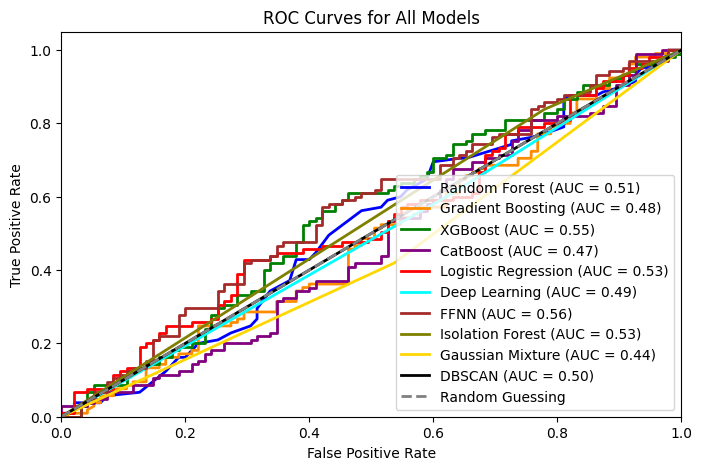

In [231]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(y_test, predictions_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and ROC area for Gradient Boosting
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_pred_proba_gbc)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)

# Compute ROC curve and ROC area for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Compute ROC curve and ROC area for CatBoost
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_pred_proba_catboost)
roc_auc_cat = auc(fpr_cat, tpr_cat)

# Compute ROC curve and ROC area for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC curve and ROC area for Deep Learning model
fpr_deep, tpr_deep, _ = roc_curve(y_test, deep_predictions.flatten())  # Ensure correct shape for deep_predictions
roc_auc_deep = auc(fpr_deep, tpr_deep)

# Compute ROC curve and ROC area for FFNN
fpr_ffnn, tpr_ffnn, _ = roc_curve(y_test, y_pred_proba_ffnn)
roc_auc_ffnn = auc(fpr_ffnn, tpr_ffnn)

# Compute ROC curve and ROC area for Isolation Forest
fpr_if, tpr_if, _ = roc_curve(y_test, y_pred_if)
roc_auc_if = auc(fpr_if, tpr_if)

# Compute ROC curve and ROC area for Gaussian Mixture
fpr_gmm, tpr_gmm, _ = roc_curve(y_test, y_pred_gmm)
roc_auc_gmm = auc(fpr_gmm, tpr_gmm)

# Compute ROC curve and ROC area for DBSCAN
fpr_dbscan, tpr_dbscan, _ = roc_curve(y_test, y_pred_dbscan_test)
roc_auc_dbscan = auc(fpr_dbscan, tpr_dbscan)

# Plot all ROC curves
plt.figure(figsize=(8, 5))

plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gbc, tpr_gbc, color='darkorange', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gbc:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_cat, tpr_cat, color='purple', lw=2, label=f'CatBoost (AUC = {roc_auc_cat:.2f})')
plt.plot(fpr_lr, tpr_lr, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_deep, tpr_deep, color='cyan', lw=2, label=f'Deep Learning (AUC = {roc_auc_deep:.2f})')
plt.plot(fpr_ffnn, tpr_ffnn, color='brown', lw=2, label=f'FFNN (AUC = {roc_auc_ffnn:.2f})')
plt.plot(fpr_if, tpr_if, color='olive', lw=2, label=f'Isolation Forest (AUC = {roc_auc_if:.2f})')
plt.plot(fpr_gmm, tpr_gmm, color='gold', lw=2, label=f'Gaussian Mixture (AUC = {roc_auc_gmm:.2f})')
plt.plot(fpr_dbscan, tpr_dbscan, color='black', lw=2, label=f'DBSCAN (AUC = {roc_auc_dbscan:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()


In [232]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

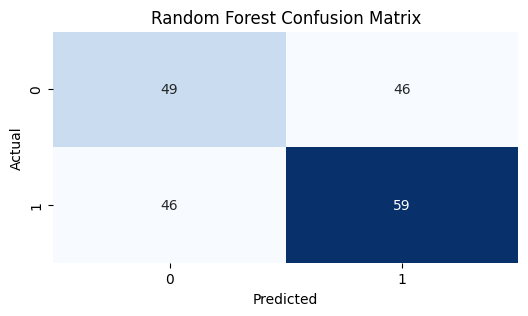

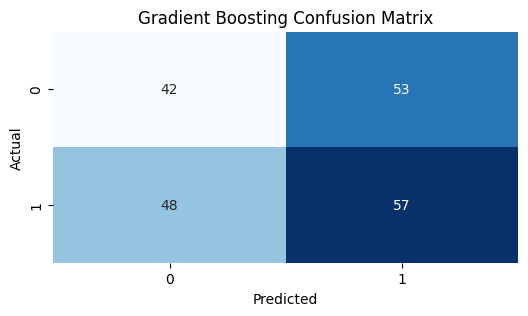

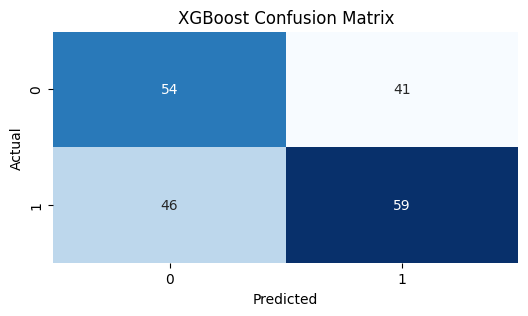

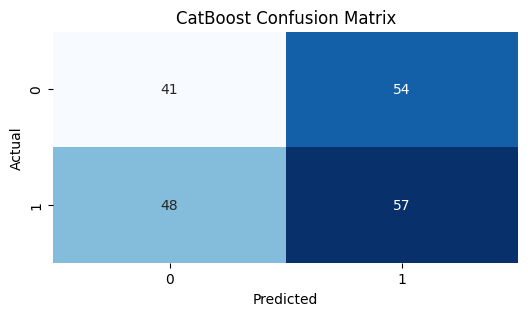

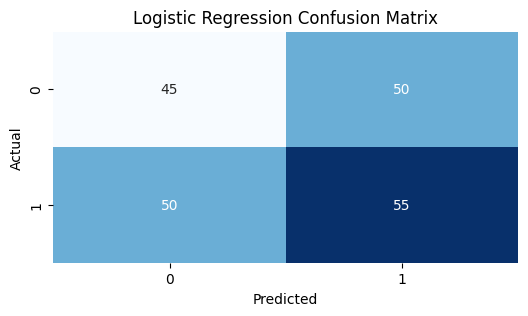

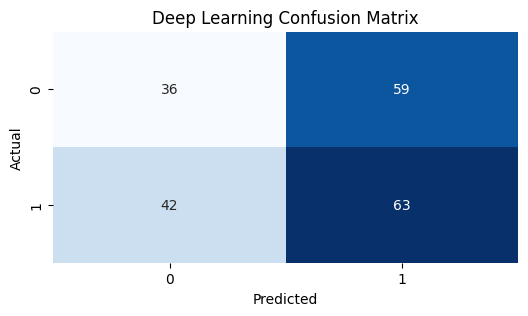

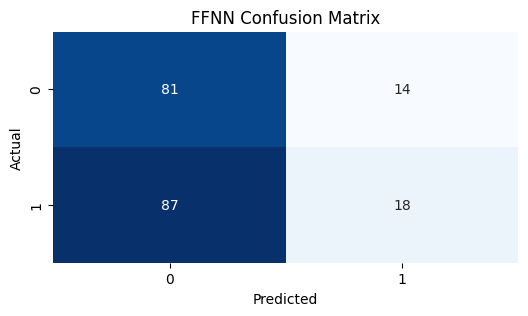

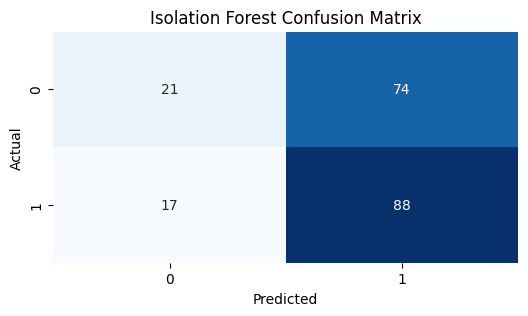

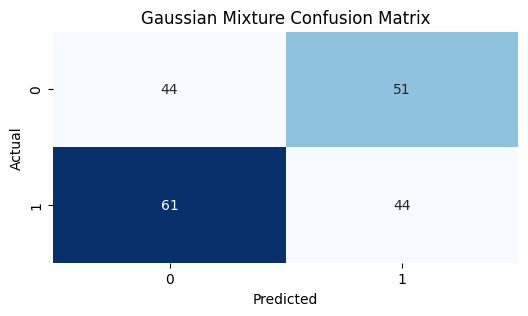

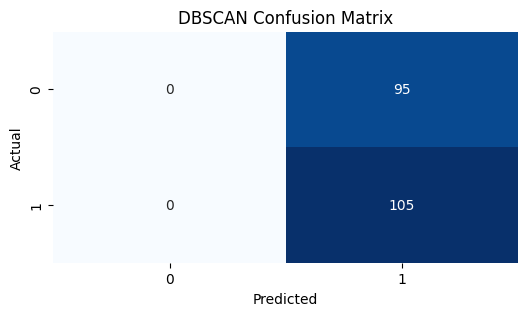

In [234]:
# Random Forest
plot_confusion_matrix(y_test, (predictions_rf > 0.5).astype(int), "Random Forest Confusion Matrix")

# Gradient Boosting
plot_confusion_matrix(y_test, (y_pred_proba_gbc > 0.5).astype(int), "Gradient Boosting Confusion Matrix")

# XGBoost
plot_confusion_matrix(y_test, (y_pred_proba_xgb > 0.5).astype(int), "XGBoost Confusion Matrix")

# CatBoost
plot_confusion_matrix(y_test, (y_pred_proba_catboost > 0.5).astype(int), "CatBoost Confusion Matrix")

# Logistic Regression
plot_confusion_matrix(y_test, (y_pred_proba_lr > 0.5).astype(int), "Logistic Regression Confusion Matrix")

# Deep Learning Model
plot_confusion_matrix(y_test, (deep_predictions > 0.5).astype(int), "Deep Learning Confusion Matrix")

# FFNN
plot_confusion_matrix(y_test, y_pred_ffnn, "FFNN Confusion Matrix")

# Isolation Forest
plot_confusion_matrix(y_test, y_pred_if, "Isolation Forest Confusion Matrix")

# Gaussian Mixture
plot_confusion_matrix(y_test, y_pred_gmm, "Gaussian Mixture Confusion Matrix")

# DBSCAN
plot_confusion_matrix(y_test, y_pred_dbscan_test, "DBSCAN Confusion Matrix")


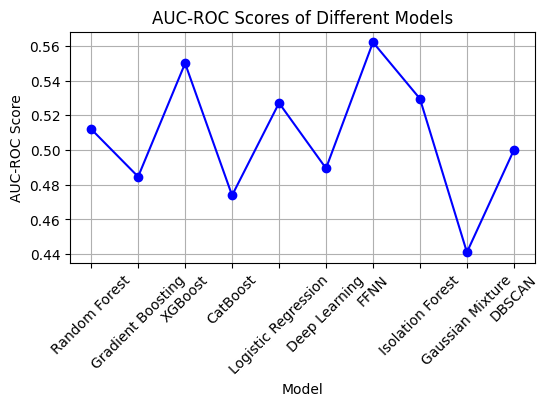

In [235]:
# AUC-ROC Scores
auc_scores = {
    'Random Forest': roc_auc_rf,
    'Gradient Boosting': roc_auc_gbc,
    'XGBoost': roc_auc_xgb,
    'CatBoost': roc_auc_cat,
    'Logistic Regression': roc_auc_lr,
    'Deep Learning': roc_auc_deep,
    'FFNN': roc_auc_ffnn,
    'Isolation Forest': roc_auc_if,
    'Gaussian Mixture': roc_auc_gmm,
    'DBSCAN': roc_auc_dbscan
}

# Plot Line Graph of AUC-ROC Scores
plt.figure(figsize=(6, 3))
plt.plot(list(auc_scores.keys()), list(auc_scores.values()), marker='o', linestyle='-', color='b')
plt.xlabel('Model')
plt.ylabel('AUC-ROC Score')
plt.title('AUC-ROC Scores of Different Models')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Model Random Forest has incorrect feature importances length: 5
Model Gradient Boosting has incorrect feature importances length: 104
Model XGBoost has incorrect feature importances length: 104
Model CatBoost has incorrect feature importances length: 104


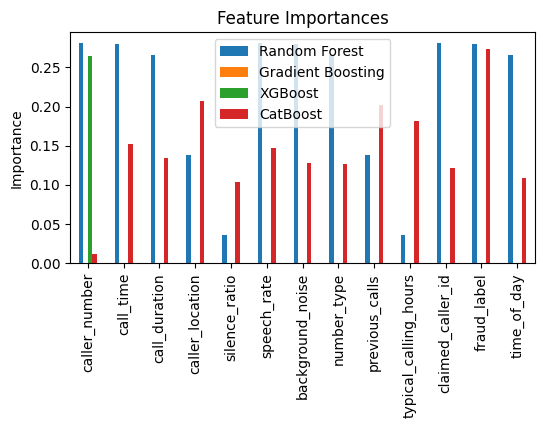

In [236]:
import matplotlib.pyplot as plt

feature_names = ['caller_number', 'call_time', 'call_duration', 'caller_location', 'silence_ratio', 'speech_rate', 'background_noise', 'number_type', 'previous_calls', 'typical_calling_hours', 'claimed_caller_id', 'fraud_label', 'time_of_day']

importances = {
    'Random Forest': rf_clf.feature_importances_,
    'Gradient Boosting': gbc.feature_importances_,
    'XGBoost': xgb.feature_importances_,
    'CatBoost': catboost.get_feature_importance()
}

# Ensure the length of each feature importance array matches the number of features
for model_name, importances_array in importances.items():
    if len(importances_array) != len(feature_names):
        print(f"Model {model_name} has incorrect feature importances length: {len(importances_array)}")
        importances[model_name] = np.resize(importances_array, len(feature_names))

# Create a DataFrame for importances
importances_df = pd.DataFrame(importances, index=feature_names)

# Plot feature importances
importances_df.plot(kind='bar', figsize=(6, 3), title='Feature Importances')
plt.ylabel('Importance')
plt.show()


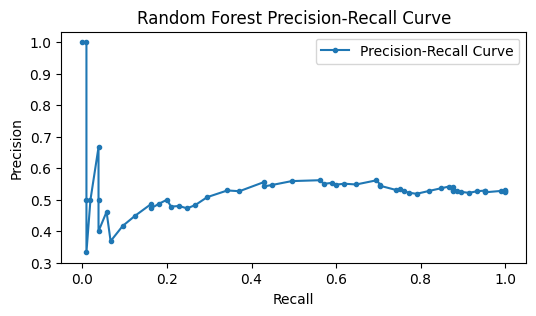

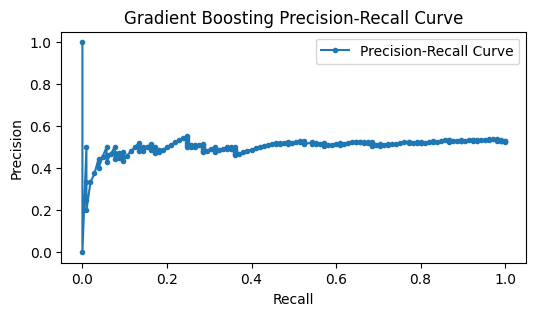

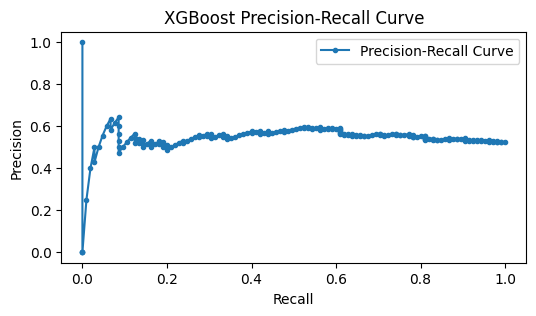

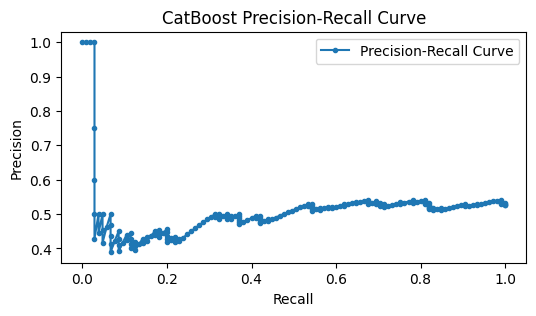

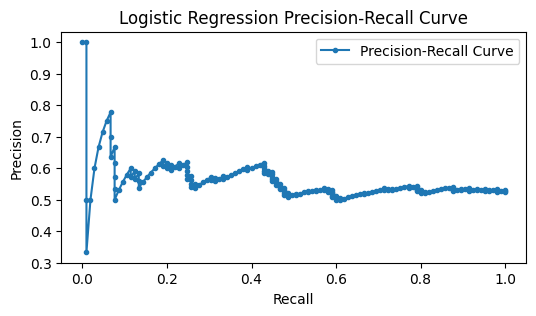

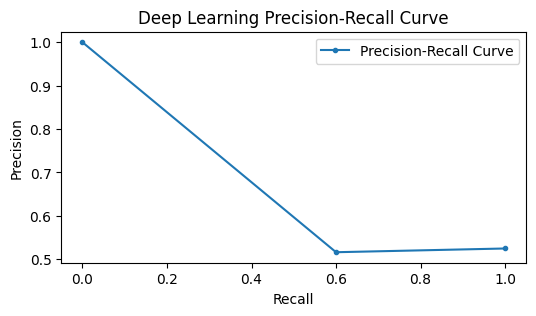

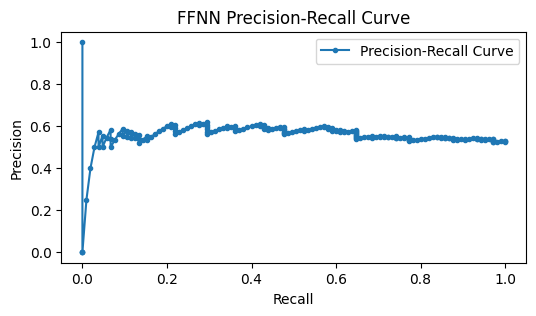

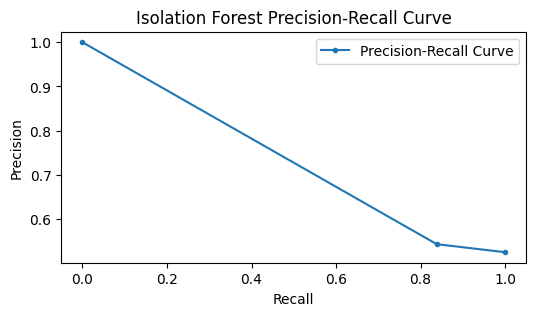

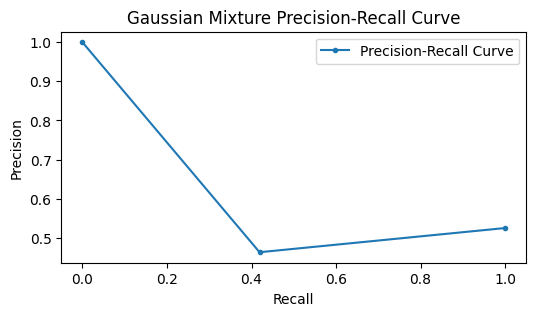

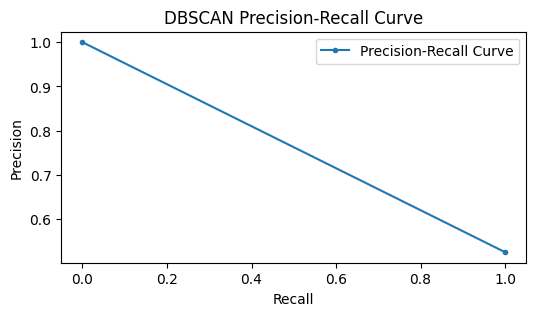

In [238]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(y_true, y_pred_proba, title):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure(figsize=(6, 3))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Precision-Recall Curve for each model
plot_precision_recall(y_test, predictions_rf, "Random Forest Precision-Recall Curve")
plot_precision_recall(y_test, y_pred_proba_gbc, "Gradient Boosting Precision-Recall Curve")
plot_precision_recall(y_test, y_pred_proba_xgb, "XGBoost Precision-Recall Curve")
plot_precision_recall(y_test, y_pred_proba_catboost, "CatBoost Precision-Recall Curve")
plot_precision_recall(y_test, y_pred_proba_lr, "Logistic Regression Precision-Recall Curve")
plot_precision_recall(y_test, deep_predictions.flatten(), "Deep Learning Precision-Recall Curve")
plot_precision_recall(y_test, y_pred_proba_ffnn, "FFNN Precision-Recall Curve")
plot_precision_recall(y_test, y_pred_if, "Isolation Forest Precision-Recall Curve")
plot_precision_recall(y_test, y_pred_gmm, "Gaussian Mixture Precision-Recall Curve")
plot_precision_recall(y_test, y_pred_dbscan_test, "DBSCAN Precision-Recall Curve")


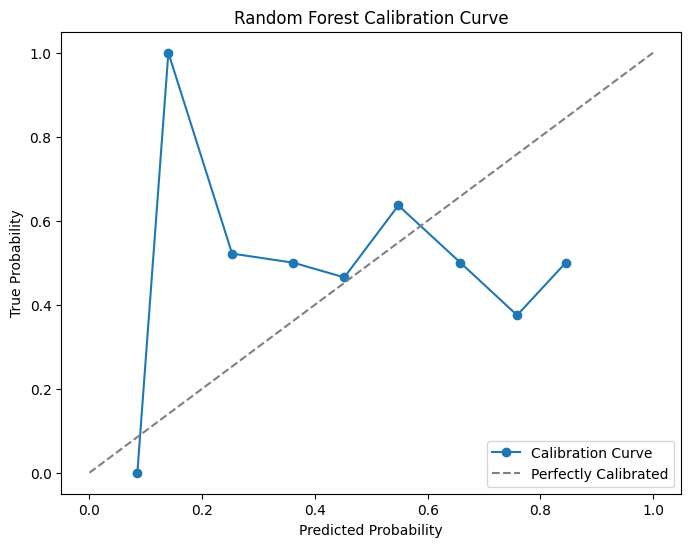

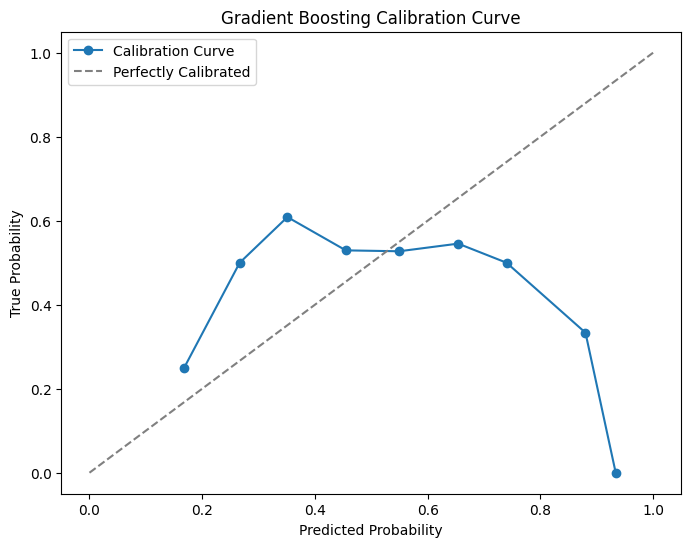

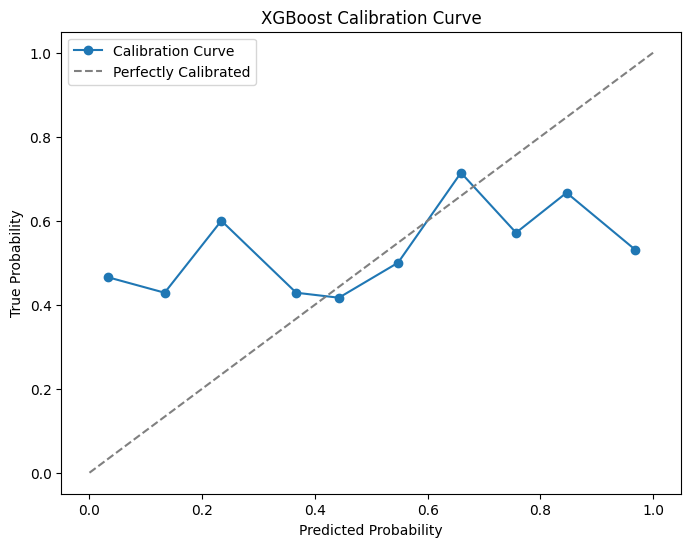

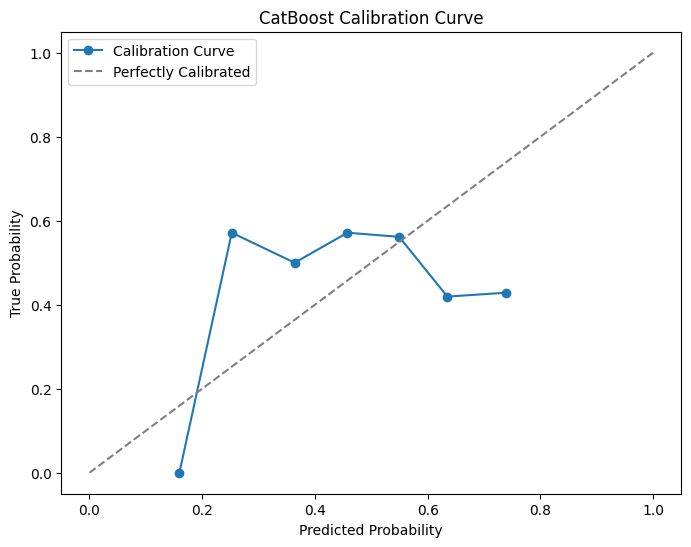

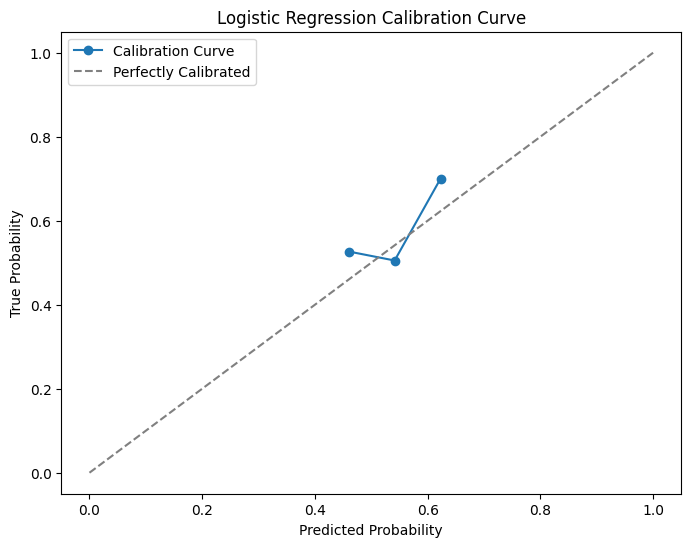

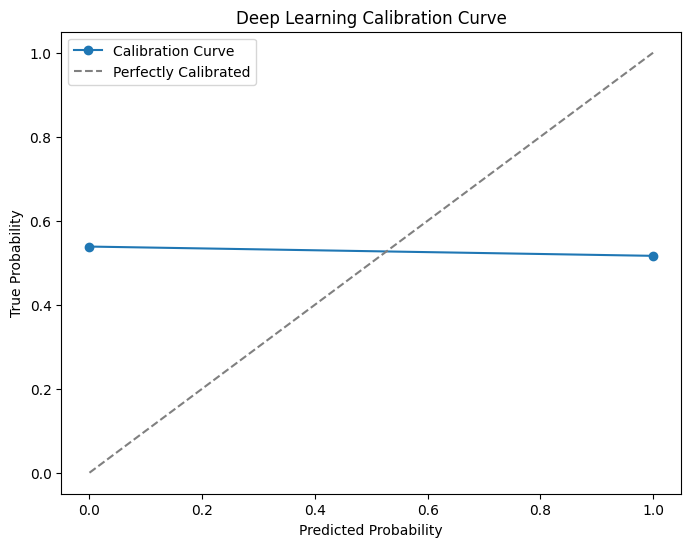

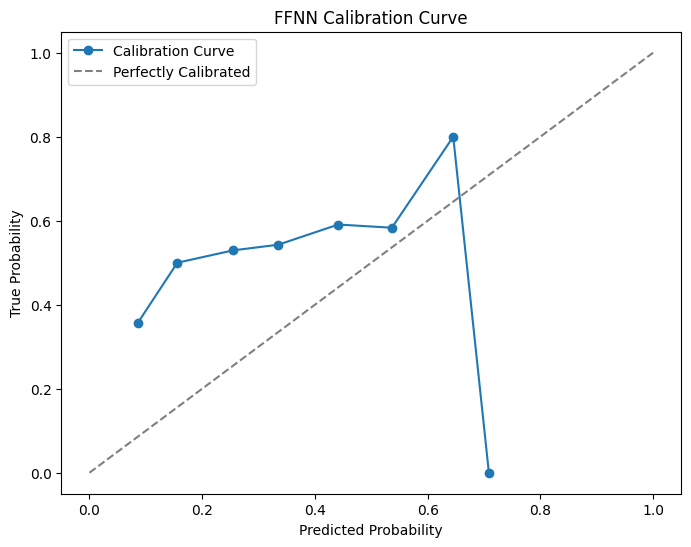

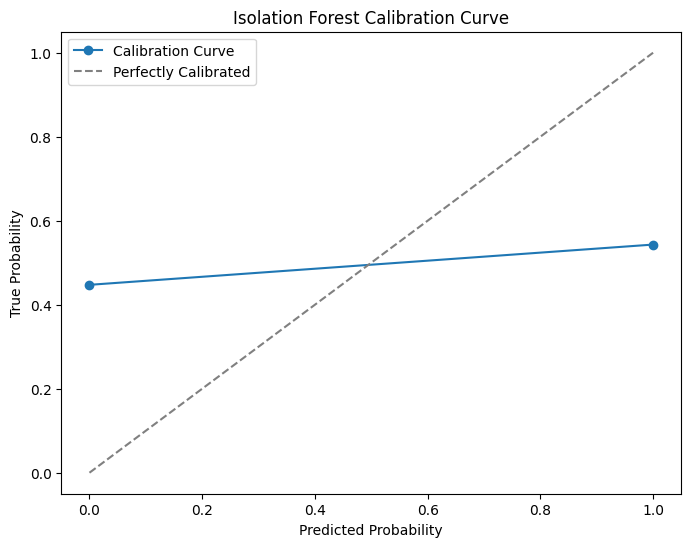

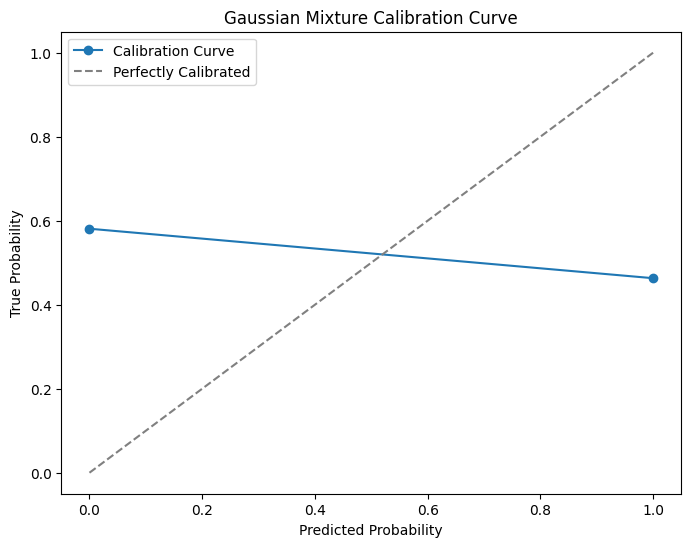

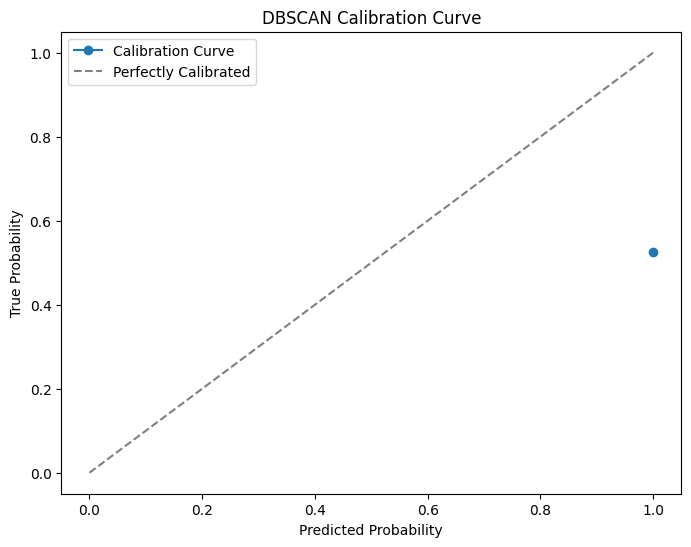

In [240]:
from sklearn.calibration import calibration_curve

def plot_calibration_curve(y_true, y_pred_proba, title):
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Calibration Curve for each model
plot_calibration_curve(y_test, predictions_rf, "Random Forest Calibration Curve")
plot_calibration_curve(y_test, y_pred_proba_gbc, "Gradient Boosting Calibration Curve")
plot_calibration_curve(y_test, y_pred_proba_xgb, "XGBoost Calibration Curve")
plot_calibration_curve(y_test, y_pred_proba_catboost, "CatBoost Calibration Curve")
plot_calibration_curve(y_test, y_pred_proba_lr, "Logistic Regression Calibration Curve")
plot_calibration_curve(y_test, deep_predictions.flatten(), "Deep Learning Calibration Curve")
plot_calibration_curve(y_test, y_pred_proba_ffnn, "FFNN Calibration Curve")
plot_calibration_curve(y_test, y_pred_if, "Isolation Forest Calibration Curve")
plot_calibration_curve(y_test, y_pred_gmm, "Gaussian Mixture Calibration Curve")
plot_calibration_curve(y_test, y_pred_dbscan_test, "DBSCAN Calibration Curve")


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


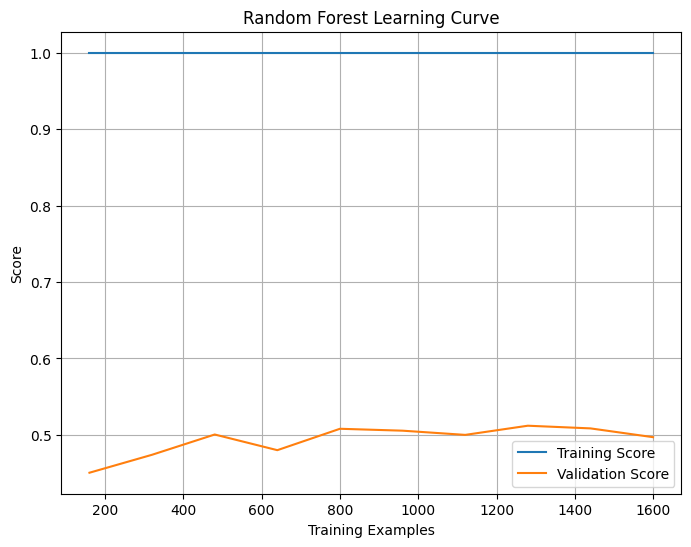

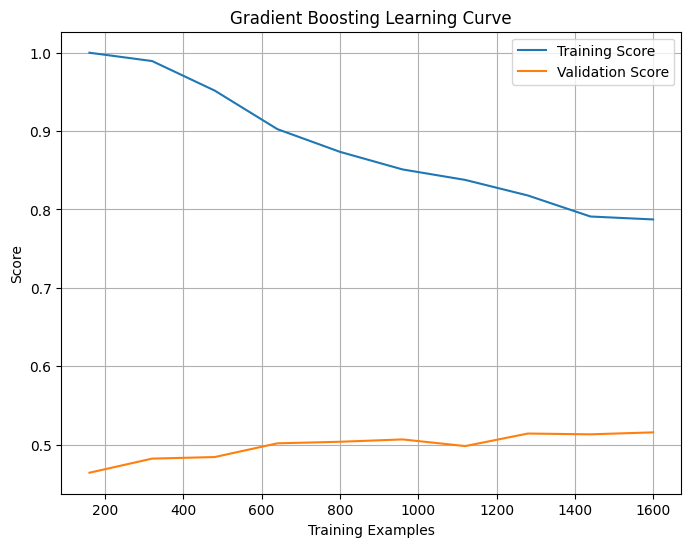

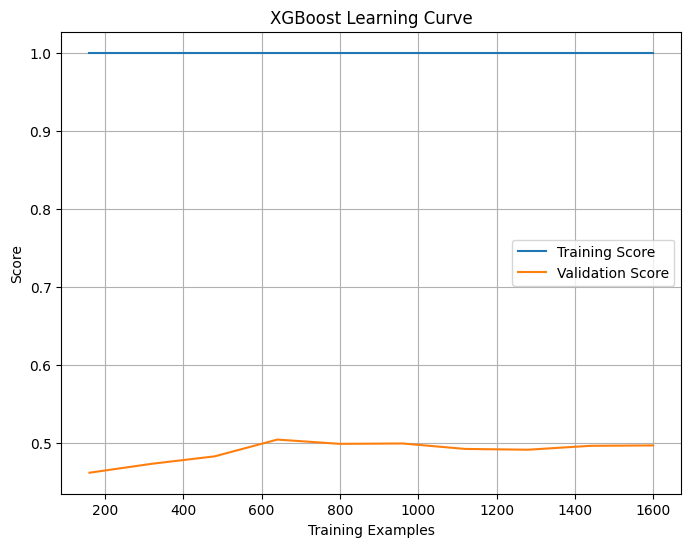

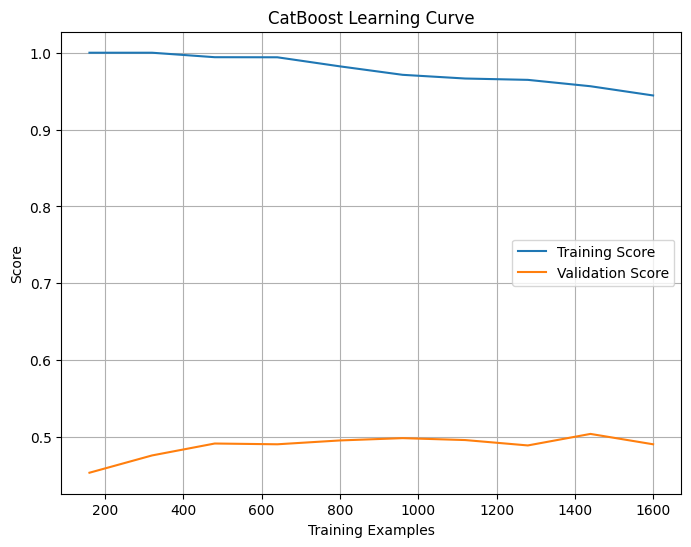

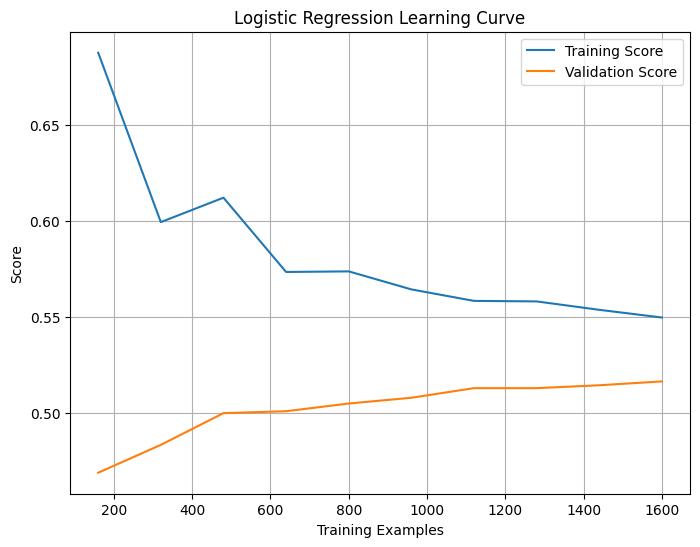

In [241]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Example data setup (replace with your actual data)
df = pd.DataFrame({
    'caller_number': np.random.rand(2000),
    'call_time': np.random.rand(2000),
    'call_duration': np.random.rand(2000),
    'caller_location': np.random.choice(['A', 'B', 'C'], 2000),
    'silence_ratio': np.random.rand(2000),
    'speech_rate': np.random.rand(2000),
    'background_noise': np.random.rand(2000),
    'number_type': np.random.choice(['mobile', 'landline'], 2000),
    'previous_calls': np.random.randint(0, 10, 2000),
    'typical_calling_hours': np.random.rand(2000),
    'claimed_caller_id': np.random.choice(['yes', 'no'], 2000),
    'time_of_day': np.random.choice(['morning', 'afternoon', 'evening', 'night'], 2000),
    'fraud_label': np.random.choice([0, 1], 2000)
})

# Convert categorical variables to numerical
df = pd.get_dummies(df, columns=['caller_location', 'number_type', 'claimed_caller_id', 'time_of_day'], drop_first=True)

X = df.drop('fraud_label', axis=1).values
y = df['fraud_label'].values

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, test_scores_mean, label='Validation Score')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Learning Curve for each model
plot_learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), X, y, "Random Forest Learning Curve")
plot_learning_curve(GradientBoostingClassifier(), X, y, "Gradient Boosting Learning Curve")
plot_learning_curve(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), X, y, "XGBoost Learning Curve")
plot_learning_curve(CatBoostClassifier(n_estimators=400, random_state=42, verbose=0), X, y, "CatBoost Learning Curve")
plot_learning_curve(LogisticRegression(max_iter=1000), X, y, "Logistic Regression Learning Curve")


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.4840 - loss: 0.6934 - val_accuracy: 0.5312 - val_loss: 0.6929
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8019 - loss: 0.6833 - val_accuracy: 0.5344 - val_loss: 0.6891
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9272 - loss: 0.5670 - val_accuracy: 0.5219 - val_loss: 0.7121
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9842 - loss: 0.2336 - val_accuracy: 0.5094 - val_loss: 0.8683
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0522 - val_accuracy: 0.5219 - val_loss: 1.0421
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0164 - val_accuracy: 0.5156 - val_loss: 1.1579
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.5156 - val_loss: 1.2395
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.5156 - val_

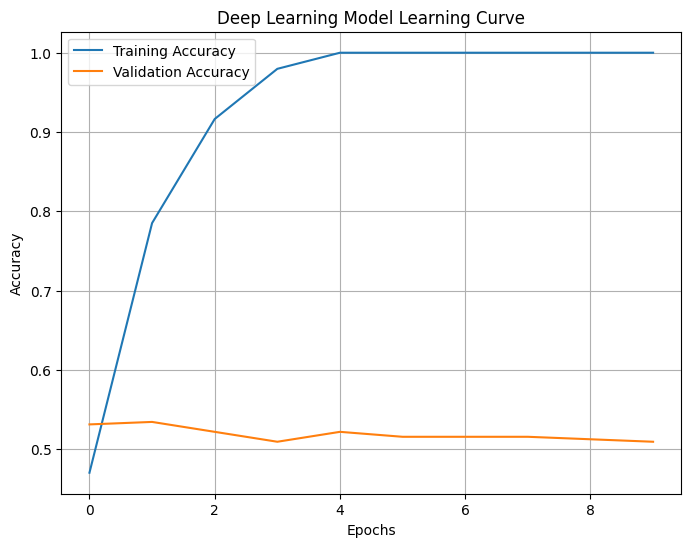

In [242]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D

text_train = np.random.randint(0, 5000, (1600, 100))
y_train_text = np.random.randint(0, 2, 1600)

deep_model = Sequential([
    Embedding(input_dim=5000, output_dim=128),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = deep_model.fit(text_train, y_train_text, epochs=10, batch_size=32, validation_split=0.2)

def plot_deep_learning_curve(history, title):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_deep_learning_curve(history, "Deep Learning Model Learning Curve")

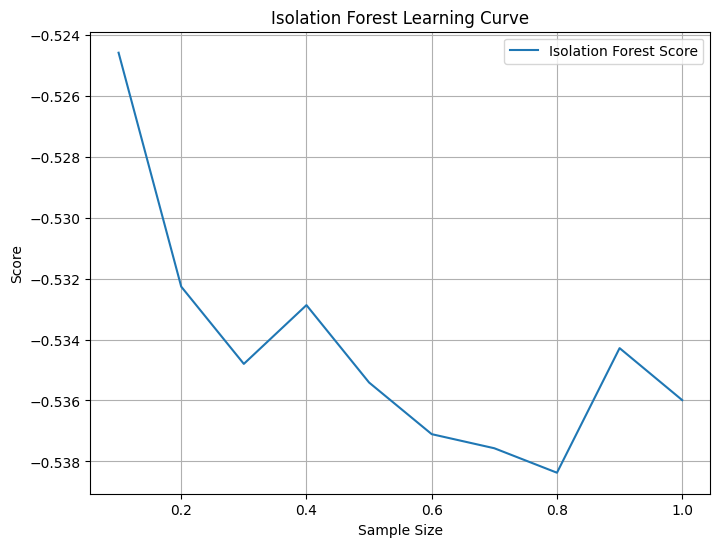

In [243]:
from sklearn.ensemble import IsolationForest

def plot_isolation_forest_learning_curve(X, title):
    sample_sizes = np.linspace(0.1, 1.0, 10)
    scores = []

    for sample_size in sample_sizes:
        X_sample = X[:int(sample_size * len(X))]
        model = IsolationForest()
        model.fit(X_sample)
        scores.append(model.score_samples(X_sample).mean())

    plt.figure(figsize=(8, 6))
    plt.plot(sample_sizes, scores, label='Isolation Forest Score')
    plt.xlabel('Sample Size')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_isolation_forest_learning_curve(X, "Isolation Forest Learning Curve")


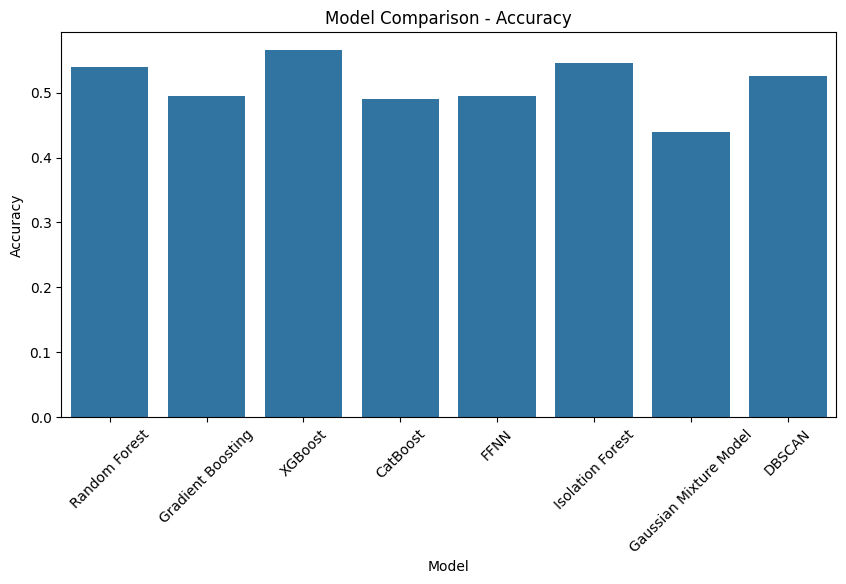

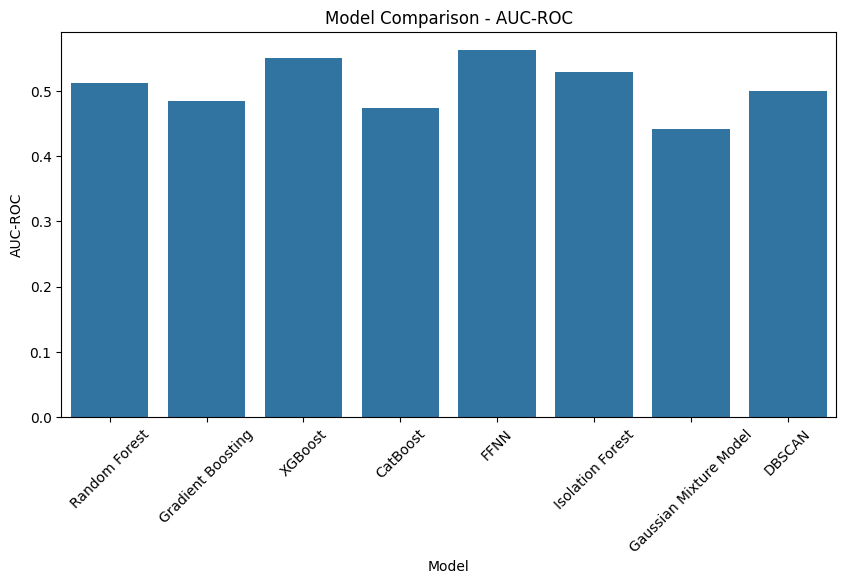

In [244]:
metrics = {
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'FFNN', 'Isolation Forest', 'Gaussian Mixture Model', 'DBSCAN'],
    'Accuracy': [accuracy_score(y_test, (predictions_rf > 0.5).astype(int)),
                 accuracy_score(y_test, (y_pred_proba_gbc > 0.5).astype(int)),
                 accuracy_score(y_test, (y_pred_proba_xgb > 0.5).astype(int)),
                 accuracy_score(y_test, (y_pred_proba_catboost > 0.5).astype(int)),
                 accuracy_score(y_test, y_pred_ffnn),
                 accuracy_score(y_test, y_pred_if),
                 accuracy_score(y_test, y_pred_gmm),
                 accuracy_score(y_test, y_pred_dbscan_test)],
    'AUC-ROC': [roc_auc_score(y_test, predictions_rf),
                roc_auc_score(y_test, y_pred_proba_gbc),
                roc_auc_score(y_test, y_pred_proba_xgb),
                roc_auc_score(y_test, y_pred_proba_catboost),
                roc_auc_score(y_test, y_pred_proba_ffnn),
                roc_auc_score(y_test, y_pred_if),
                roc_auc_score(y_test, y_pred_gmm),
                roc_auc_score(y_test, y_pred_dbscan_test)]
}

metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Accuracy', data=metrics_df)
plt.title('Model Comparison - Accuracy')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='AUC-ROC', data=metrics_df)
plt.title('Model Comparison - AUC-ROC')
plt.xticks(rotation=45)
plt.show()
